In [ ]:
# Dependencies 
# !pip3 install torch torchvision torchaudio
# !pip3 install nuscenes-devkit

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from PIL import Image
import torch.nn.functional as F
from IPython.display import Image as IPImage

In [ ]:
from nuscenes.can_bus.can_bus_api import NuScenesCanBus
from nuscenes.nuscenes import NuScenes
PATH = '/Users/jonathanmorris/Downloads/v1.0-mini'

nusc = NuScenes(version='v1.0-mini', dataroot=PATH, verbose=True)
nusc_can = NuScenesCanBus(dataroot=PATH)

In [ ]:
nusc.list_scenes()

In [ ]:
# Selecting first scene
my_scene = nusc.scene[3]
my_scene

In [ ]:
log = nusc.get('log', my_scene['log_token'])
log

In [ ]:
# Getting data from can expansion
my_scene_zoe_can = nusc_can.get_messages(my_scene['name'], 'zoesensors')
my_scene_zoe_can[0]

In [ ]:
my_scene_imu_can = nusc_can.get_messages(my_scene['name'], 'ms_imu')
my_scene_imu_can[0]

In [ ]:
my_scene_vehicle_monitor_can = nusc_can.get_messages(my_scene['name'], 'vehicle_monitor')
my_scene_vehicle_monitor_can[0]

In [ ]:
# Get first sample
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
my_sample

In [ ]:
print(nusc_can.can_blacklist)
print(nusc.scene[0]['name'])
print(int(nusc.scene[0]['name'].split("-")[1]))

In [ ]:
def get_closest_can(time, can_objects):
    closest = {}
    prev_diff = 1000000 # 1 Second in microseconds
    for object in can_objects:
        diff = object["utime"] - time
        if diff > 0 and diff < prev_diff:
            closest = object
            prev_diff = diff
    # print("Time difference: ", prev_diff)
    return closest

def normalize(value, min, max):
    # Figure out how 'wide' each range is
    leftSpan = max - min

    # Convert the left range into a 0-1 range (float)
    return float(value - min) / float(leftSpan)

def normalize_zoe_can(can_obj):
    new_obj = {}
    
    # These values are from here: https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/can_bus/README.md#zoe-sensors
    min_breaking = 0.166
    max_breaking = 0.631

    min_steering = 0.176
    max_steering = 0.252
    
    min_throttle = 0.105
    max_throttle = 0.411

    # convert values from 0-1
    new_obj["brake_sensor"] = normalize(can_obj["brake_sensor"], min_breaking, max_breaking)
    new_obj["steering_sensor"] = normalize(can_obj["steering_sensor"], min_steering, max_steering)
    new_obj["throttle_sensor"] = normalize(can_obj["throttle_sensor"], min_throttle, max_throttle)

    # reduce precision
    new_obj["brake_sensor"] = round(can_obj["brake_sensor"], 2)
    new_obj["steering_sensor"] = round(can_obj["steering_sensor"], 2)
    new_obj["throttle_sensor"] = round(can_obj["throttle_sensor"], 2)
    
    return new_obj

def normalize_vehicle_monitor_can(can_obj):
    new_obj = {}

    min_brake = 0
    max_break = 126

    min_steering = -780
    max_steering = 779.9

    min_throttle = 0
    max_throttle = 1000

    new_obj["brake"] = normalize(can_obj["brake"], min_brake, max_break)
    new_obj["steering"] = normalize(can_obj["steering"], min_steering, max_steering)
    new_obj["throttle"] = normalize(can_obj["throttle"], min_throttle, max_throttle)

    return new_obj

In [ ]:
can_data = get_closest_can(my_sample['timestamp'], my_scene_zoe_can)
can_data


In [ ]:
normalize_zoe_can(can_data)

In [ ]:
imu_data = get_closest_can(my_sample['timestamp'], my_scene_imu_can)
imu_data

In [ ]:
# Acceleration on x, y, z axis, m/s^2
acc = imu_data['linear_accel']
acc

In [ ]:
acc = torch.tensor([acc[0], acc[1], acc[2]])
acc

In [ ]:
# Check tensor size
acc.size()

In [ ]:
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
current_image_path = PATH+"/"+cam_front_data['filename']

In [ ]:
img = Image.open(current_image_path)
convert_tensor = transforms.ToTensor()
tensor = convert_tensor(img)
tensor.size()

In [ ]:
def get_next_data(scene, sample):
    next_token = sample["next"]
    next_sample = nusc.get("sample", next_token)
    can_data = nusc_can.get_messages(scene['name'], 'zoesensors')
    get_closest_can(next_sample["timestamp"], my_scene_zoe_can)
    return (next_sample, can_data)

get_next_data(my_scene,my_sample)

In [ ]:
class LaneCNN(nn.Module):
    def __init__(self):
        super(LaneCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 3) # output three values -> [steering, throttle, breaking]

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = x.view(256 * 28 * 28)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class MultiModalModel(nn.Module):
    def __init__(self):
        super(MultiModalModel, self).__init__()
        # Image processing branch - Convolutional layers
        self.image_branch = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),  # Adjusted input size
            nn.ReLU()
        )
        # Float processing branch - Fully connected layers
        self.float_branch = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU()
        )
        # Final output layer
        self.final_layer = nn.Linear(128 + 32, 3)

    def forward(self, image, floats):
        image_out = self.image_branch(image)
        float_out = self.float_branch(floats)
        float_out = float_out.unsqueeze(0).repeat(image_out.size(0), 1)

        # Concatenate the outputs of the two branches
        concat_out = torch.cat((image_out, float_out), dim=1)
        
        # Pass through final layer
        out = self.final_layer(concat_out)
        return out

In [44]:
learning_rate = 0.001
batch_size = 64
epochs = 10
model_path = os.path.join(os.getcwd(), "models")

!mkdir models && cd models && mkdir epochs

print(model_path)
transform = transforms.Compose(
        [transforms.Resize((224, 224), antialias=True), transforms.ToTensor()]
    )
model_file_name = "nuscenes_model_v1.1.pth"

mkdir: models: File exists
/Users/jonathanmorris/Developer/cruz-control/nuscenes/lane_following/models


In [ ]:
def train():
    # path = sys.argv[1]
    print("Model Version V1.1")
    print("final model weights will be saved to: " + model_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "mps")

    scenes = nusc.scene

    train_size = int(0.8 * len(scenes))
    val_size = len(scenes) - train_size
    train, val = random_split(scenes, [train_size, val_size])

    # multithreaded data loading
    trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)

    valloader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=2)

    net = LaneCNN().to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    print(f"Training on {device}")

    for epoch in range(epochs):
        net.train()
        for scene in trainloader:
            for scene in scenes:
                scene_number = int(scene['name'].split("-")[1])

                if scene_number in nusc_can.can_blacklist:
                    print("Skipping scene " + str(scene_number))
                    continue
                
                first_sample_token = scene['first_sample_token']

                current_sample = nusc.get('sample', first_sample_token)

                scene_vehicle_monitor = nusc_can.get_messages(scene['name'], 'vehicle_monitor')

                while True:
                    sensor = "CAM_FRONT"
                    cam_front_data = nusc.get("sample_data", current_sample["data"][sensor])
                    current_image_path = PATH + "/" + cam_front_data["filename"]
                    img = Image.open(current_image_path)

                    img_input = transform(img).to(device)
                
                    current_vehicle_can = get_closest_can(current_sample["timestamp"], scene_vehicle_monitor)                    

                    if current_vehicle_can == {}:
                        if current_sample['next'] == '':
                            break
                        else:
                            current_sample = nusc.get('sample', current_sample['next'])
                            continue

                    normal_vm_can = normalize_vehicle_monitor_can(current_vehicle_can)

                    steering_targets = normal_vm_can['steering']
                    throttle_targets = normal_vm_can['throttle']
                    breaking_targets = normal_vm_can['brake']

                    label = torch.FloatTensor([steering_targets, throttle_targets, breaking_targets]).to(device)              

                    optimizer.zero_grad()
                    
                    # Forward pass
                    outputs = net(img_input)

                    # Compute loss
                    total_loss = criterion(outputs, label)

                    # Backward pass
                    total_loss.backward()

                    # Update weights
                    optimizer.step()

                    if current_sample['next'] == '':
                        break
                    else:
                        current_sample = nusc.get('sample', current_sample['next'])

        # Validation
        net.eval()
        with torch.no_grad():
            for scene in valloader:
                for scene in scenes:
                    scene_number = int(scene['name'].split("-")[1])

                    if scene_number in nusc_can.can_blacklist:
                        print("Skipping scene " + str(scene_number))
                        continue

                    first_sample_token = scene['first_sample_token']

                    current_sample = nusc.get('sample', first_sample_token)

                    scene_vehicle_monitor = nusc_can.get_messages(scene['name'], 'vehicle_monitor')
                    scene_imu_cans = nusc_can.get_messages(scene['name'], 'ms_imu')

                    while True:
                        sensor = "CAM_FRONT"
                        cam_front_data = nusc.get("sample_data", current_sample["data"][sensor])
                        current_image_path = PATH + "/" + cam_front_data["filename"]
                        img = Image.open(current_image_path)

                        img_input = transform(img).to(device)

                        current_vehicle_can = get_closest_can(current_sample["timestamp"], scene_vehicle_monitor)

                        if current_vehicle_can == {}:
                            if current_sample['next'] == '':
                                break
                            else:
                                current_sample = nusc.get('sample', current_sample['next'])
                                continue
                        
                        normal_vm_can = normalize_vehicle_monitor_can(current_vehicle_can)

                        steering_targets = normal_vm_can['steering']
                        throttle_targets = normal_vm_can['throttle']
                        breaking_targets = normal_vm_can['brake']

                        label = torch.FloatTensor([steering_targets, throttle_targets, breaking_targets]).to(device)

                        outputs = net(img_input)

                        val_total_loss = criterion(outputs, label)

                        if current_sample['next'] == '':
                            break
                        else:
                            current_sample = nusc.get('sample', current_sample['next'])

        print(
            f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss.item():.4f}, Validation Loss: {val_total_loss.item():.4f}"
        )
        torch.save(
            net.state_dict(),
            os.path.join(model_path, "epochs", f"model_e{epoch+1}.pth"),
        )

    print("Finished training")
    torch.save(net.state_dict(), os.path.join(model_path, model_file_name))

In [ ]:
train()

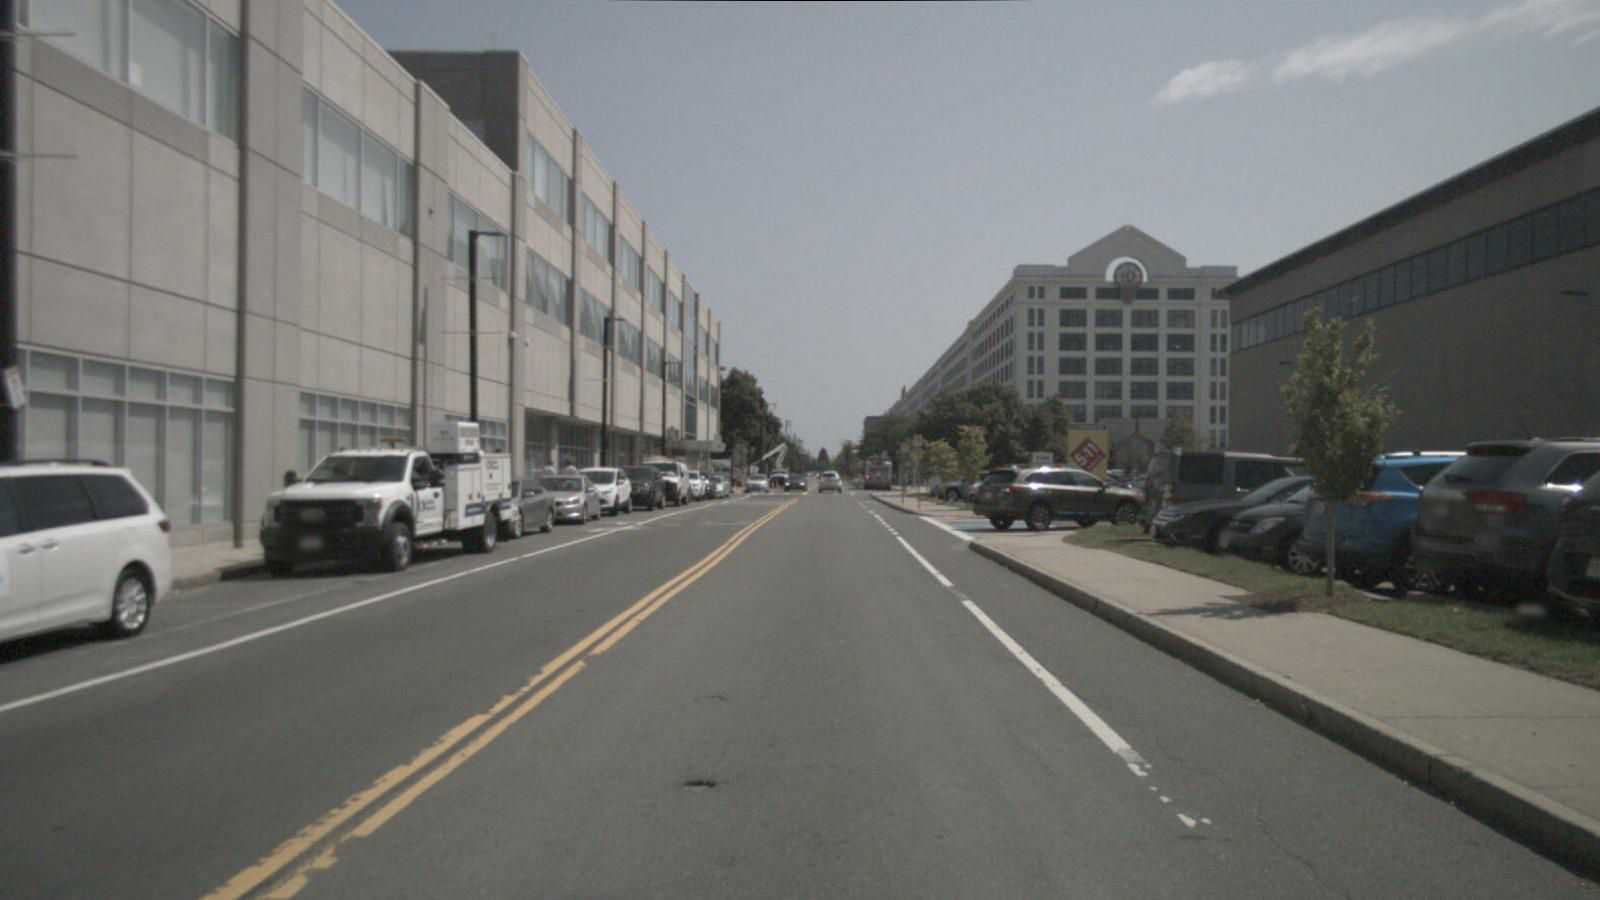

In [42]:
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
current_image_path = PATH+"/"+cam_front_data['filename']
img = Image.open(current_image_path)
transformer = transforms.ToTensor()
image_tensor = transform(img)
IPImage(filename=current_image_path) 

In [43]:
model = LaneCNN()
model.load_state_dict(torch.load(model_path + "/" + model_file_name, map_location=torch.device('mps')))
model.eval()
model(image_tensor)

tensor([0.5468, 0.2314, 0.0121], grad_fn=<ViewBackward0>)